In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, f1_score, accuracy_score
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.utils import class_weight

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import pearsonr

In [2]:
data = pd.read_csv('training_data/eurusd_final_dataset.csv')

# I am dropping because I don't want to use these features in the model currently
X = data.drop(['label', 'Date_Time', 'hour', 'dayofweek', 'mins_into_m15', 'frac_into_m15'], axis=1)
y = data['label']

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Attempting to create a NN with the whole data set, using changed weights - Failed

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

# Use the integer version of the labels here
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to a dict if needed
class_weights = dict(enumerate(class_weights))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_cat, class_weight=class_weights, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
3837/3837 [==============================] - 18s 4ms/step - loss: 1.3467 - accuracy: 0.5228 - val_loss: 1.1866 - val_accuracy: 0.5386
Epoch 2/20
3837/3837 [==============================] - 17s 4ms/step - loss: 1.3235 - accuracy: 0.5433 - val_loss: 1.1862 - val_accuracy: 0.5391
Epoch 3/20
3837/3837 [==============================] - 17s 4ms/step - loss: 1.3177 - accuracy: 0.5461 - val_loss: 1.1504 - val_accuracy: 0.5503
Epoch 4/20
3837/3837 [==============================] - 17s 5ms/step - loss: 1.3141 - accuracy: 0.5454 - val_loss: 1.1737 - val_accuracy: 0.5368
Epoch 5/20
3837/3837 [==============================] - 17s 4ms/step - loss: 1.3116 - accuracy: 0.5467 - val_loss: 1.1710 - val_accuracy: 0.5512
Epoch 6/20
3837/3837 [==============================] - 17s 4ms/step - loss: 1.3090 - accuracy: 0.5458 - val_loss: 1.1620 - val_accuracy: 0.5509
Epoch 7/20
3837/3837 [==============================] - 17s 5ms/step - loss: 1.3082 - accuracy: 0.5461 - val_loss: 1.1455 - val_ac

In [ ]:
# Predict
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Metrics
print("Keras Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
#sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
#plt.xlabel("Predicted")
#plt.ylabel("True")
#plt.show()

# Per-class Precision/Recall/F1
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
for i in range(5):
    print(f"Class {i} — Precision: {prec[i]:.2f}, Recall: {rec[i]:.2f}, F1: {f1[i]:.2f}")

1066/1066 [==============================] - 3s 3ms/step
Keras Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75     16072
           1       0.50      0.40      0.44     12110
           2       0.26      0.33      0.29      3738
           3       0.16      0.31      0.21      1243
           4       0.24      0.28      0.26       941

    accuracy                           0.55     34104
   macro avg       0.38      0.41      0.39     34104
weighted avg       0.57      0.55      0.56     34104

Confusion Matrix:
Class 0 — Precision: 0.75, Recall: 0.75, F1: 0.75
Class 1 — Precision: 0.50, Recall: 0.40, F1: 0.44
Class 2 — Precision: 0.26, Recall: 0.33, F1: 0.29
Class 3 — Precision: 0.16, Recall: 0.31, F1: 0.21
Class 4 — Precision: 0.24, Recall: 0.28, F1: 0.26


In [ ]:
# Simulated trade logic example: TP = +2, SL = -1 per class prediction
profit_rules = {0: 2, 1: -1, 2: 2, 3: -1, 4: 0}

# Assume true class is the correct "direction" — reward if prediction matches
profits = [profit_rules[p] if p == t else -1 for p, t in zip(y_pred, y_test)]
total_profit = sum(profits)

print(f"Simulated Profit: {total_profit}")

#### Attempting to create an NN but with rolling window

In [8]:
# 164 windows

# Parameters
window_size = 5000
val_size = 1000
step = 1000

input_features = X_scaled.shape[1]

def build_model(input_dim):
    model = Sequential([
        Input(shape=(input_features,)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Tracking
f1_per_window, acc_per_window = [], []
vol_per_window, trend_15_per_window, vol_1h_per_window = [], [], []
window_indices = []
profit_agressive_per_window = []
profit_conservative_per_window = []
trades_aggressive_per_window = []
trades_conservative_per_window = []

volatility_local = data['vol_local'].values
trend_15m = data['roll_m15_trend'].values
vol_1h = data['roll_h1_vol'].values

for i, start in enumerate(range(0, len(X_scaled) - window_size - val_size, step)):
    train_X = X_scaled[start:start+window_size]
    val_X = X_scaled[start+window_size:start+window_size+val_size]
    train_y = y[start:start+window_size]
    val_y = y[start+window_size:start+window_size+val_size]

    train_y_cat = to_categorical(train_y, num_classes=5)
    val_y_cat = to_categorical(val_y, num_classes=5)

    cw = dict(enumerate(class_weight.compute_class_weight(
        class_weight='balanced', classes=np.unique(train_y), y=train_y)))

    model = build_model(train_X.shape[1])
    model.fit(train_X, train_y_cat,
              validation_data=(val_X, val_y_cat),
              epochs=30, batch_size=32,
              class_weight=cw,
              callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
              verbose=0)

    preds = np.argmax(model.predict(val_X, verbose=0), axis=1)

    # Metrics
    f1 = f1_score(val_y, preds, average='weighted')
    acc = accuracy_score(val_y, preds)

    # Direction maps
    direction_aggressive = {0: -1, 1: -1, 2: 0, 3: 1, 4: 1}
    direction_conservative = {0: -1, 1: 0, 2: 0, 3: 0, 4: 1}

    # Get pip changes
    future_price = data['Close'].shift(-step).values
    current_price = data['Close'].values

    val_start = start + window_size
    max_len = min(val_size, len(data) - val_start - step)

    current = current_price[val_start:val_start + max_len]
    future = future_price[val_start:val_start + max_len]
    actual_pips = (future - current) * 10_000

    # Initialize trackers
    profit_aggressive = 0
    profit_conservative = 0
    trades_aggressive = 0
    trades_conservative = 0
    cost_per_trade = 1.5  # in pips

    for pred, pip in zip(preds[:max_len], actual_pips):
        # Aggressive strategy
        dir_agg = direction_aggressive[pred]
        if dir_agg != 0:
            realized = dir_agg * pip - cost_per_trade
            profit_aggressive += realized
            trades_aggressive += 1

        # Conservative strategy
        dir_con = direction_conservative[pred]
        if dir_con != 0:
            realized = dir_con * pip - cost_per_trade
            profit_conservative += realized
            trades_conservative += 1
    
    # Log profits
    profit_agressive_per_window.append(profit_aggressive)
    profit_conservative_per_window.append(profit_conservative)
    trades_aggressive_per_window.append(trades_aggressive)
    trades_conservative_per_window.append(trades_conservative)

    # Log
    f1_per_window.append(f1)
    acc_per_window.append(acc)
    vol_per_window.append(np.mean(volatility_local[start+window_size:start+window_size+val_size]))
    trend_15_per_window.append(np.mean(trend_15m[start+window_size:start+window_size+val_size]))
    vol_1h_per_window.append(np.mean(vol_1h[start+window_size:start+window_size+val_size]))
    window_indices.append(i)

    print(f"Window {i}: F1 = {f1:.3f}, Acc = {acc:.3f}, Profit (agg) = {profit_aggressive:.1f} pips, Profit (cons) = {profit_conservative:.1f} pips, Trades: {trades_aggressive}/{trades_conservative}")

Window 0: F1 = 0.575, Acc = 0.536, Profit (agg) = -4543.0 pips, Profit (cons) = -5908.9 pips, Trades: 414/377
Window 1: F1 = 0.615, Acc = 0.588, Profit (agg) = 53470.9 pips, Profit (cons) = 27934.1 pips, Trades: 357/213
Window 2: F1 = 0.467, Acc = 0.387, Profit (agg) = -10563.3 pips, Profit (cons) = 239.3 pips, Trades: 634/61
Window 3: F1 = 0.671, Acc = 0.625, Profit (agg) = -5129.6 pips, Profit (cons) = -4419.9 pips, Trades: 323/144
Window 4: F1 = 0.563, Acc = 0.510, Profit (agg) = -13398.3 pips, Profit (cons) = -7793.6 pips, Trades: 440/228
Window 5: F1 = 0.651, Acc = 0.600, Profit (agg) = -4582.1 pips, Profit (cons) = -81.1 pips, Trades: 372/73
Window 6: F1 = 0.550, Acc = 0.517, Profit (agg) = 924.1 pips, Profit (cons) = 361.2 pips, Trades: 435/97
Window 7: F1 = 0.530, Acc = 0.459, Profit (agg) = 31608.1 pips, Profit (cons) = 1126.1 pips, Trades: 554/63
Window 8: F1 = 0.376, Acc = 0.335, Profit (agg) = -22783.5 pips, Profit (cons) = -23985.8 pips, Trades: 667/443
Window 9: F1 = 0.47

In [9]:
print("\n📉 Correlation with Accuracy:")
print(f"1H Volatility: {pearsonr(acc_per_window, vol_1h_per_window)[0]:.2f}")
print(f"15m Trend: {pearsonr(acc_per_window, trend_15_per_window)[0]:.2f}")
print(f"Local volatility: {pearsonr(acc_per_window, vol_per_window)[0]:.2f}")


print("\n📈 Correlation with F1 Score:")
print(f"1H Volatility: {pearsonr(f1_per_window, vol_1h_per_window)[0]:.2f}")
print(f"15m Trend:     {pearsonr(f1_per_window, trend_15_per_window)[0]:.2f}")
print(f"Local volatility: {pearsonr(f1_per_window, vol_per_window)[0]:.2f}")


📉 Correlation with Accuracy:
1H Volatility: -0.68
15m Trend: -0.17
Local volatility: -0.68

📈 Correlation with F1 Score:
1H Volatility: -0.80
15m Trend:     -0.20
Local volatility: -0.80


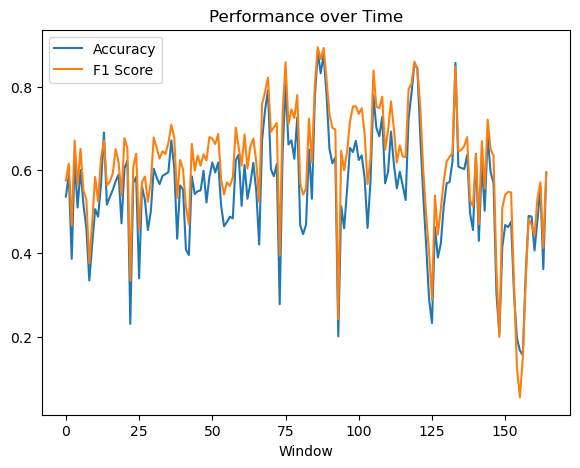

In [10]:
# Optional: plot drift
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(window_indices, acc_per_window, label="Accuracy")
plt.plot(window_indices, f1_per_window, label="F1 Score")
plt.xlabel("Window")
plt.title("Performance over Time")
plt.legend()

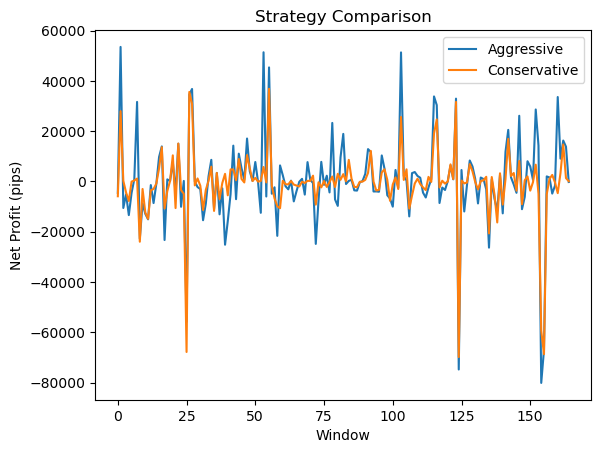

In [11]:
plt.plot(profit_agressive_per_window, label='Aggressive')
plt.plot(profit_conservative_per_window, label='Conservative')
plt.xlabel('Window')
plt.ylabel('Net Profit (pips)')
plt.legend()
plt.title('Strategy Comparison')
plt.show()

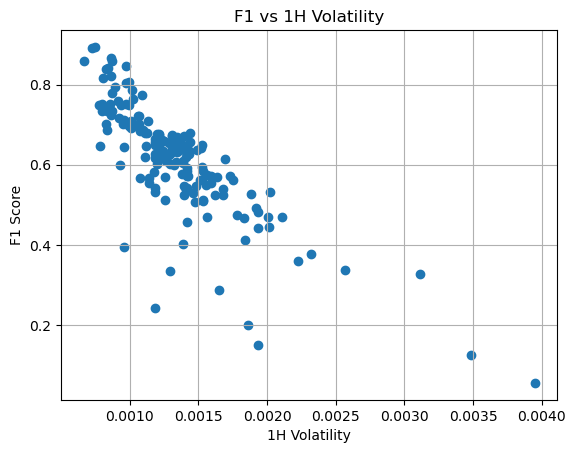

In [12]:
plt.figure()
plt.scatter(vol_1h_per_window, f1_per_window)
plt.xlabel("1H Volatility")
plt.ylabel("F1 Score")
plt.title("F1 vs 1H Volatility")
plt.grid(True)
plt.show()

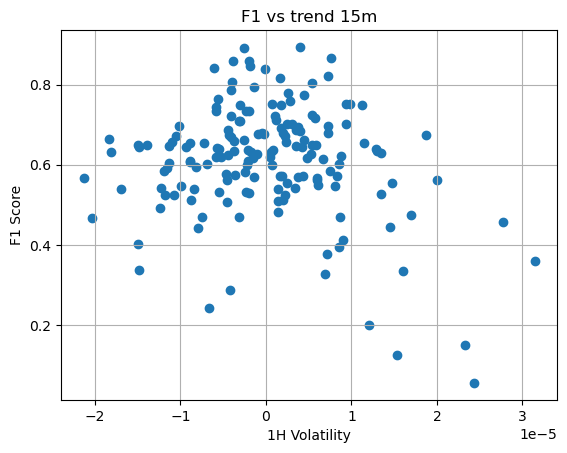

In [13]:
plt.figure()
plt.scatter(trend_15_per_window, f1_per_window)
plt.xlabel("1H Volatility")
plt.ylabel("F1 Score")
plt.title("F1 vs trend 15m")
plt.grid(True)
plt.show()

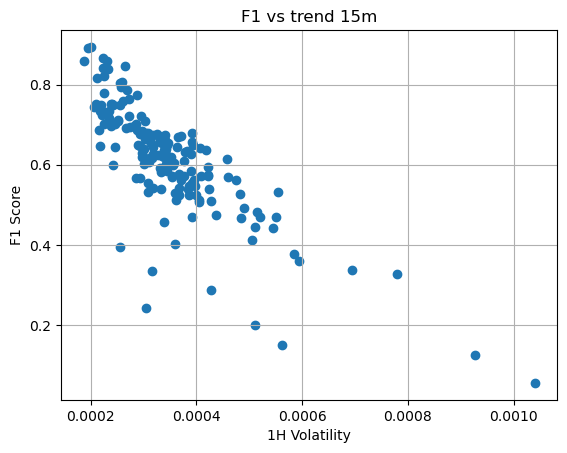

In [14]:
plt.figure()
plt.scatter(vol_per_window, f1_per_window)
plt.xlabel("1H Volatility")
plt.ylabel("F1 Score")
plt.title("F1 vs trend 15m")
plt.grid(True)
plt.show()